In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pybnesian as pbn
from .util_draw import *
from .util_metrics import *
from .util_syntethic import *
import time 

### SIMULATE DATA
Atienza ref: \
https://github.com/davenza/SPBN-Experiments/blob/master/synthetic/test_hc_spbn.py

10 arcs for key 2
21 arcs for key 13
7 arcs for key 3
14 arcs for key 4


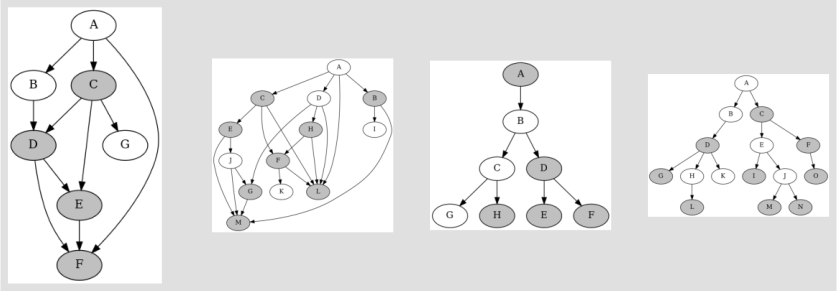

In [2]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

config = get_config(1)
print(len(config['arcs']), 'arcs for key 2')
ref_model0 = pbn.SemiparametricBN(**config)
plot_model(ref_model0,ax[0])

config = get_config(2)
ref_model0 = pbn.SemiparametricBN(**config)
plot_model(ref_model0,ax[1])
print(len(config['arcs']), 'arcs for key 13')


config = get_config(3)
ref_model0 = pbn.SemiparametricBN(**config)
plot_model(ref_model0,ax[2])
print(len(config['arcs']), 'arcs for key 3')

config = get_config(4)
ref_model0 = pbn.SemiparametricBN(**config)
plot_model(ref_model0,ax[3])
print(len(config['arcs']), 'arcs for key 4')



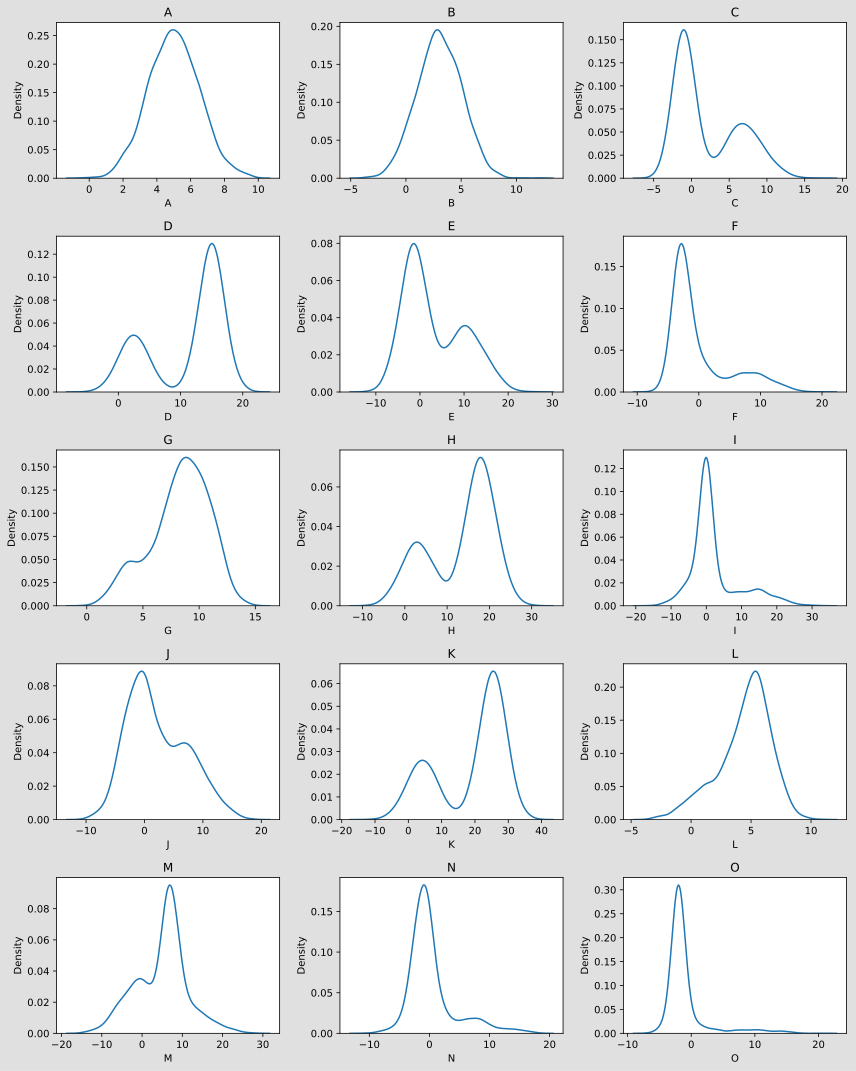

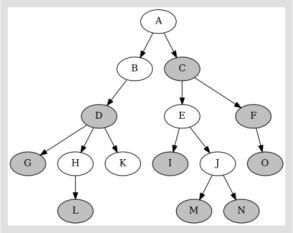

In [3]:
key = 4
data = generate_data(key,2000,seed=20)
config = get_config(key)


nodemap = {node: i for i, node in enumerate(data.columns.values)}

fig, axs = plt.subplots(5, 3, figsize=(12, 15))
for i, col in enumerate(data.columns):
    sns.kdeplot(data[col], ax=axs[i // 3, i % 3])
    axs[i // 3, i % 3].set_title(col)


plt.tight_layout()
plt.show()

ref_model0 = pbn.SemiparametricBN(nodes = list(data.columns.values), **config)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_model(ref_model0,ax)

In [ ]:
ntrain, ntest = 2**12, 2**11 
print(ntrain, ntest)

# good synthetic data: 2 
train = generate_data(key, ntrain, seed=0)
test = generate_data(key, ntest, seed=255)

ref_model0.fit(train)
logl_ref = ref_model0.logl(test)
print(np.sum(logl_ref))


4096 2048
Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M'], dtype='object')
-56726.17149618662


(-56673.76757867567, -56726.17149618662)
   HMD  SHD      rmse  relative_err  train time  test_time
0  1.0    1  0.208307      0.441355  113.772503   0.799781


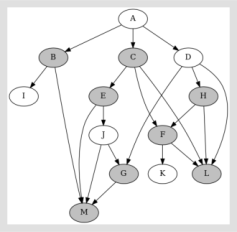

(-56673.76757867567, -56726.17149618662)
   HMD  SHD      rmse  relative_err  train time  test_time
1  1.0    1  0.208307      0.441355  106.641647   0.814591


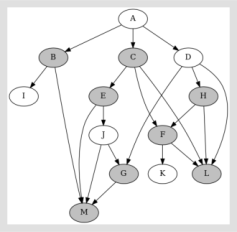

(-56673.76757867567, -56726.17149618662)
   HMD  SHD      rmse  relative_err  train time  test_time
2  1.0    1  0.208307      0.441355    107.0394    0.91362


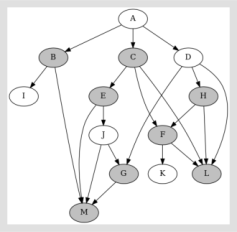

,HMD,SHD,rmse,relative_err,train time,test_time
0,1.0,1,0.208307,0.441355,113.772503,0.799781
1,1.0,1,0.208307,0.441355,106.641647,0.814591
2,1.0,1,0.208307,0.441355,107.039400,0.913620


In [6]:
executions = []
for i in range(3):
    hc = pbn.GreedyHillClimbing()
    vl = pbn.ValidatedLikelihood(train, k=5)
    pool = pbn.OperatorPool([pbn.ArcOperatorSet(), pbn.ChangeNodeTypeSet()])
    

    emptynet = pbn.SemiparametricBN(list(data.columns.values))
    start = time.time()
    model = hc.estimate(pool, vl, emptynet, patience = 3, max_indegree = 5)
    end = time.time()
    train_time = end - start
    
    model.fit(train)
    
    start = time.time()
    logl_pred = model.logl(test)
    end = time.time()
    test_time = end - start

    print((np.sum(logl_pred), np.sum(logl_ref)))


    hmd = hamming_distance(model.arcs(), config['arcs'], nodemap)
    shd = structural_hamming_distance(model.arcs(), config['arcs'])

    rmse = np.sqrt(np.mean((logl_pred - logl_ref)**2))
    relative_err = np.mean(np.abs(logl_pred - logl_ref) / np.abs(logl_ref))*100

    executions.append(pd.DataFrame({'HMD': hmd, 'SHD': shd, 'rmse':rmse, 'relative_err':relative_err,'train time':train_time, 'test_time': test_time}, index=[i]))
    print(executions[-1])

    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    plot_model(model,ax)
    plt.show()

df_spbn = pd.concat(executions)
df_spbn

In [7]:
mean_spbn = df_spbn.mean().to_frame().T
mean_spbn

,HMD,SHD,rmse,relative_err,train time,test_time
0,1.0,1.0,0.208307,0.441355,109.151183,0.842664


(-65268.73188999963, -65023.38308833284)


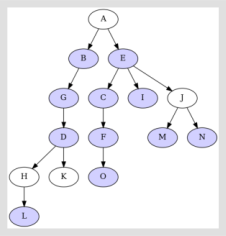

(-65008.71501897311, -65023.38308833284)


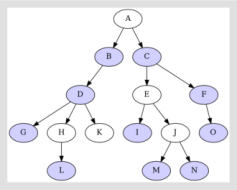

(-65350.72560515823, -65023.38308833284)


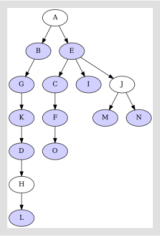

(-65116.145308328, -65023.38308833284)


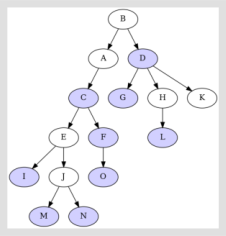

(-65329.48678777521, -65023.38308833284)


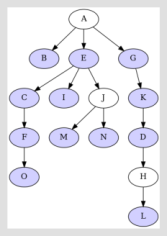

In [ ]:
grid = 50
linear = True
fft = True
fit_fbn = dict(grid=grid, linear=linear, use_fft=fft)
executions = []
for i in range(10):
    hc = pbn.GreedyHillClimbing()
    # vl = pbn.CVLikelihoodFT(train, k=10,
    #                     grid_size=grid, linear_binning=False, use_fft=False)

    vl = pbn.ValidatedLikelihoodFT(train, k=5,
                                   grid_size=grid, linear_binning=linear, use_fft=fft)

    pool = pbn.OperatorPool([pbn.ArcOperatorSet(), pbn.ChangeNodeTypeSet()])
    

    emptynet = pbn.FourierNetwork(list(data.columns.values))
    start = time.time()
    model = hc.estimate(pool, vl, emptynet, patience = 5, max_indegree = 1)
    end = time.time()
    train_time = end - start
    
    model.fit(train,**fit_fbn)
    
    start = time.time()
    logl_pred = model.logl(test)
    end = time.time()
    test_time = end - start

    print((np.sum(logl_pred), np.sum(logl_ref)))
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    plot_model(model, ax)
    plt.show()


    hmd = hamming_distance(model.arcs(), config['arcs'], nodemap)
    shd = structural_hamming_distance(model.arcs(), config['arcs'])
    rmse = np.sqrt(np.mean((logl_pred - logl_ref)**2))
    relative_err = np.mean(np.abs(logl_pred - logl_ref) / np.abs(logl_ref))*100
    executions.append(pd.DataFrame({'HMD': hmd, 'SHD': shd, 'rmse':rmse, 'relative_err':relative_err,'train time':train_time, 'test_time': test_time}, index=[i]))

df_fsbn = pd.concat(executions)
df_fsbn

In [10]:
mean_fsbn = df_fsbn.mean().to_frame().T
mean_fsbn

,HMD,SHD,rmse,relative_err,train time,test_time
0,1.2,2.2,0.211241,0.889833,73.211863,0.758648


In [11]:
mean_spbn/mean_fsbn

,HMD,SHD,rmse,relative_err,train time,test_time
0,0.666667,0.590909,0.207323,0.199503,1.214571,1.514149


### NASA BENCHMARKS
https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/

#### CMAPSS 

In [ ]:
def read_data(path):
  df = pd.read_csv(path, delimiter=' ', header=None)
  # check null ratios of each columns
  rc = df.isnull().sum(axis=0)/len(df)
  print(rc[rc!=0.])
  return df

names = ['unit', 'time',
         'altitude', 'mach', 'TRA',
         'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr',
         'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']

df_train1 = read_data('data/aingura/public_datasets/train_FD001.txt')
df_train2 = read_data('data/aingura/public_datasets/train_FD002.txt')
df_train3 = read_data('data/aingura/public_datasets/train_FD003.txt')
df_train4 = read_data('data/aingura/public_datasets/train_FD004.txt')
# remove full of null columns
df_train1.drop([26, 27], axis=1, inplace=True)
df_train1.columns = names
df_train2.drop([26, 27], axis=1, inplace=True)
df_train2.columns = names
df_train3.drop([26, 27], axis=1, inplace=True)
df_train3.columns = names
df_train4.drop([26, 27], axis=1, inplace=True)
df_train4.columns = names


In [ ]:
df_trains_sealvl = pd.concat([df_train1, df_train3],axis=0).reset_index(drop=True)
df_trains_sealvl.to_csv('data/aingura/public_datasets/nasa_repos/6_cmapss_trains_sealvl.csv', index=False)
df_trains_sealvl

In [ ]:
df_trains_six = pd.concat([df_train2, df_train4],axis=0).reset_index(drop=True)
df_trains_six.to_csv('data/aingura/public_datasets/nasa_repos/6_cmapss_trains_six.csv', index=False)
df_trains_six

In [ ]:
df_test1 = read_data('data/aingura/public_datasets/test_FD001.txt')
df_test2 = read_data('data/aingura/public_datasets/test_FD002.txt')
df_test3 = read_data('data/aingura/public_datasets/test_FD003.txt')
df_test4 = read_data('data/aingura/public_datasets/test_FD004.txt')

# remove full of null columns
df_test1.drop([26, 27], axis=1, inplace=True)
df_test1.columns = names
df_test2.drop([26, 27], axis=1, inplace=True)
df_test2.columns = names
df_test3.drop([26, 27], axis=1, inplace=True)
df_test3.columns = names
df_test4.drop([26, 27], axis=1, inplace=True)
df_test4.columns = names

In [ ]:
df_test_sealvl = pd.concat([df_test1, df_test3], axis=0).reset_index(drop=True)
df_test_sealvl.to_csv('data/aingura/public_datasets/nasa_repos/6_cmapss_tests_sealvl.csv', index=False)
df_test_sealvl

In [ ]:
df_test_six = pd.concat([df_test2, df_test4], axis=0).reset_index(drop=True)
df_test_six.to_csv('data/aingura/public_datasets/nasa_repos/6_cmapss_tests_six.csv', index=False)
df_test_six

In [ ]:
for n in names:
    print(n, df_test_six[n].nunique(), df_test_sealvl[n].nunique())
    print(n, df_trains_six[n].nunique(), df_trains_sealvl[n].nunique())



#### IGBT data 

In [ ]:
from scipy.io import loadmat

# Replace 'your_file.mat' with the path to your MATLAB file
mat_data = loadmat('data/aingura/IGBTAgingData_04022009/IGBTAgingData_04022009/Data/Thermal Overstress Aging with DC at gate/20080429T135531.mat')

mat_data.keys()



In [130]:
names = ['GATE_VOLTAGE', 'COLLECTOR_VOLTAGE', 'HEAT_SINK_TEMP', 'GATE_CURRENT', 'COLLECTOR_CURRENT', 'TIME', 'PACKAGE_TEMP']

vars = {}
for n in names:
    vars[n] = mat_data[n].flatten()

df = pd.DataFrame(vars)
df.to_csv('data/aingura/nasa_repos/8.igbt-the_thermal_overstress_aging_with_dc_at_gate.csv', index=False)

#### milling

In [81]:
from scipy.io import loadmat
import pandas as pd


In [88]:
mat_data = loadmat('data/aingura/nasa_repos/3. Milling/mill.mat',simplify_cells=True)

mill = mat_data['mill']
pandas_df = []
for i in range(len(mill)):
    df = pd.DataFrame(mill[i])
    pandas_df.append(df)
pandas_df = pd.concat(pandas_df, axis=0)
pandas_df.to_csv('data/aingura/nasa_repos/3_mill.csv', index=False)


#### 16 stellite power simulation

In [ ]:
mat_data = loadmat('data/aingura/nasa_repos/16. Small Satellite Power Simulation Data Set/PK31.mat',simplify_cells=True)
mat_data.keys()

In [ ]:

data['step'][0]['comment']

In [ ]:
data = mat_data['data']
print(data.keys())

data['mode'][0].keys(), data['step'][0].keys()

In [ ]:
item = data['mode']
pandas_df = []
for i in range(len(item)):
    item_new = {k: v for k, v in item[i].items() if k != 'comment'}

    # print(item_new)
    try:
        df = pd.DataFrame(item_new)
    except:
        df = pd.DataFrame(item_new, index=[i])
    pandas_df.append(df)
pandas_df = pd.concat(pandas_df, axis=0)
# pandas_df.to_csv('data/aingura/nasa_repos/16_PK35_mode.csv', index=False)
print(pandas_df.info())
item = data['step']
pandas_df = []
for i in range(len(item)):
    item_new = {k: v for k, v in item[i].items() if k != 'comment'}

    # print(item_new)
    try:
        df = pd.DataFrame(item_new)
    except:
        df = pd.DataFrame(item_new, index=[i])
    pandas_df.append(df)
pandas_df = pd.concat(pandas_df, axis=0)
# pandas_df.to_csv('data/aingura/nasa_repos/16_PK35_step.csv', index=False)
pandas_df

### UCI REPOSITORY
https://archive.ics.uci.edu/datasets?FeatureTypes=Numerical&Python=true&skip=0&take=10&sort=desc&orderBy=NumHits&search=


In [9]:
from ucimlrepo import fetch_ucirepo 

savepath = 'data/aingura/uci_repos/'

In [ ]:
# fetch dataset 
individual_household_electric_power_consumption = fetch_ucirepo(id=235) 
  
# data (as pandas dataframes) 
X = individual_household_electric_power_consumption.data.features 
y = individual_household_electric_power_consumption.data.targets 
  
X
# X.to_csv(savepath+'individual_household_electric_power_consumption.csv', index=False)

In [ ]:
individual_household_electric_power_consumption.metadata

In [21]:
# fetch dataset 
appliances_energy_prediction = fetch_ucirepo(id=374) 
  
# data (as pandas dataframes) 
X = appliances_energy_prediction.data.features 
y = appliances_energy_prediction.data.targets 

X
# X.to_csv(savepath+'appliances_energy_prediction.csv', index=False)

In [ ]:
appliances_energy_prediction.metadata

In [26]:
# fetch dataset 
magic_gamma_telescope = fetch_ucirepo(id=159) 
  
# data (as pandas dataframes) 
X = magic_gamma_telescope.data.features 
y = magic_gamma_telescope.data.targets 

X
# X.to_csv(savepath+'magic_gamma_telescope.csv', index=False)

In [ ]:
magic_gamma_telescope.metadata

In [37]:
# fetch dataset 
single_elder_home_monitoring_gas_and_position = fetch_ucirepo(id=799) 
  
# data (as pandas dataframes) 
X = single_elder_home_monitoring_gas_and_position.data.features 
y = single_elder_home_monitoring_gas_and_position.data.targets 

X
X.to_csv(savepath+'single_elder_home_monitoring_gas_and_position.csv', index=False)

In [ ]:
single_elder_home_monitoring_gas_and_position.metadata

In [41]:
# fetch dataset 
htru2 = fetch_ucirepo(id=372) 
  
# data (as pandas dataframes) 
X = htru2.data.features 
y = htru2.data.targets 

X
# X.to_csv(savepath+'htru2.csv', index=False)

In [ ]:
htru2.metadata

In [46]:
# fetch dataset 
occupancy_detection = fetch_ucirepo(id=357) 
  
# data (as pandas dataframes) 
X = occupancy_detection.data.features 
y = occupancy_detection.data.target

X
X.to_csv(savepath+'occupancy_detection.csv', index=False)

In [ ]:
occupancy_detection.metadata